# RAG (Retrieval Augmented Generation)

[Original paper by Lewis et a. (2020)](https://arxiv.org/abs/2005.11401)

Was macht RAG?

Ein ganz simpler Vergleich:

Wenn man einen Menschen bittet, eine Aufgabe zu erledigen, dann tut er dies meist anhand von gelerntem Wissen, er kann aber auch ein Hilfsmittel benutzen, z.B. im Internet recherchieren.

- Das gelernte Wissen entspricht dem trainierten LLM.
- Das Hilfsmittel entspricht RAG.

Wenn man möchte, dass das LLM Spezialwissen hat, kann man also

- Das LLM fine tunen
- Ein RAG hinzuschalten

RAG und Fine tuning kurz im Vergleich:

- Fine tunen ist mit mehr Aufwand verbunden. Man muss z.B. seine Daten auf ein sauberes Format bekommen. Ein Modell auf einen Datensatz zu tunen, bringt außerdem oft andere Seiteneffekte mit sich, z.B. kann das Modell dabei zuvor Gelerntes wieder vergessen.
- Fine tuning ist schwer erweiterbar, weil das Modell jedes Mal neu getuned werden muss. RAG ist ganz leicht erweiterbar.
- Beim Fine tunen wird das Modell auf alle vorhandenen Daten trainiert, somit limitiert die Tokenanzahl der nachgeschlagenen Dokumente nicht die Gesamtmenge an Informationen, mit der das LLM arbeiten kann.
- Ein getunetes Modell liefert deutlich schneller Antworten, weil es nicht erst nachschlagen muss.
- RAG-Systeme selbst (also nicht das Training, sondern die Anwendung selbst) sind i.d.R. komplexer.


## Wie funktioniert RAG, was macht RAG kompliziert?

Wenn man Spezialwissen in einer möglicherweise riesigen Datenquelle finden möchte, muss man wissen, wo man suchen muss.

Menschen in einer Bibliothek suchen für gewöhnlich in alphabetisch sortierten Regalen. Handwerker suchen Schrauben in Kistchen, die der Schraubengröße entsprechend angeordnet sind ...

Diese Art von Suche ist für unsortierte oder unstrukturierte Daten nicht praktikabel. Man muss also anders suchen. Dieses Notebook beschäftigt sich hauptsächlich mit dem "Finden von relevanten Dokumenten".

Wir möchten vier technische Konzepte vorstellen, die für das Finden von Daten nützlich sind:

- BM25 (Einzelwörter)
- Text-Embeddings (semantische Ähnlichkeit)
- Sparse Vectors mit Splade (Einzelwörter, semantische Ähnlichkeit)
- Cross-Encoding (Vergleicht Texte direkt, "Reranker")

Man kann z.B. für ein RAG nur Text-Embeddings benutzen, oder eine Kombination von Embeddings, BM25 und Reranking.


## BM25 (Okapi BM25)

Der Klassiker. Wird z.B. von Google oder Elasticsearch benutzt um zu einer Anfrage Webseiten oder Dokumente zurück zu liefern.

BM25 erstellt von allen Dokumenten eine Art Liste (einen Index), in der steht, wie oft welches Wort im Dokument auftaucht. Wenn ich nun z.B. in Google einen Satz eintippe, sieht Google nach, wie oft meine Suchwörter in den Einträgen der von Google erstellten Liste (Index) vorkommen. Die relevantesten Webseiten werden mir angezeigt.

BM25 ist sehr schnell.


#### Wie sieht dieser Index aus?


In [ ]:
from rank_bm25 import BM25Okapi
from helpers import pp

bm25 = BM25Okapi([pp(k) for k in ["Hello, hello World", "Hey Joe, hi hey joe"]])

print(bm25.doc_freqs)

#### Wir bauen einen Mini-BM25-Retriever mit Langchain


In [ ]:
from langchain_community.document_loaders.text import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

documents = TextLoader("state_of_the_union.txt").load()
documents_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=64)
split_documents = documents_splitter.split_documents(documents)

In [ ]:
# Hier läuft für Demo-Zwecke alles in-memory. Natürlich hätte man in Produktion für so etwas ElasticSearch o.Ä.
from langchain_community.retrievers import BM25Retriever
from helpers import pretty_print_docs

retriever = BM25Retriever.from_documents(split_documents, k=3)
query = "What did the president say about Ketanji Brown Jackson"
results = retriever.get_relevant_documents(query)
pretty_print_docs(results)

## Embeddings (Text-Embeddings, Vektoren)

#### Embeddings sind meist ein ganz grundlegender Baustein von LLM-basierten Applikationen. Wir versuchen hier, so kurz wie möglich aber so umfassend wie nötig das Konzept Embedding zu erklären.

Beim Einbetten wird ein Textstück genommen und von einem einen ML-Modell in einen hochdimensionalen Vektor umgewandelt (eigentlich: auf einen Vektor projeziert).

Es gibt unterschiedliche Methoden, wie dieser Vektor erstellt wird und die genaue Art und Weise, wie der Embeddingprozess vonstattengeht, ist eine kleine Wissenschaft für sich.

**Allerdings haben alle Text-Embeddings folgende Eigenschaft: Wenn zwei Textstücke semantisch ähnlichen Inhalt haben, liegen die resultierenden Vektoren nahe beieinander.**

**Man erhält durch den Embeddingprozess also eine Möglichkeit, sehr viele (!) Textstücke, zusammen mit der Information, wie ähnlich sich diese Texte inhaltlich sind, abzuspeichern!**

Vektoren (i.e. Embeddings) können vom Computer sehr schnell verarbeitet werden. Man kann damit dann so schöne Dinge tun wie:

- Suche (wobei die Ergebnisse nach semantischer Relevanz geordnet werden)
- Clustering (wobei Textzeichenfolgen nach Ähnlichkeit gruppiert werden)
- Empfehlungen (wobei Elemente mit zugehörigen Textzeichenfolgen empfohlen werden)
- Anomalieerkennung (wobei Ausreißer mit geringem Zusammenhang identifiziert werden)
- Klassifizierung (wobei Textzeichenfolgen nach ihrer ähnlichsten Bezeichnung klassifiziert werden)

Eine Standard-Suchanwendung läuft wie folgt ab:

- Alle Dokumente, die eine Wissensdatenbank bilden sollen, (z.B. Betriebsanleitungen eines Maschinenherstellers) werden **im Vorhinein** vektorisiert (Kann etwas dauern).
- Dann stellt ein Nutzer eine Anfrage an die KI (bezüglich einer Maschine des Maschinenherstellers).
- Diese Frage wird ebenfalls vektorisiert (geht relativ schnell).
- Dann wird in den Vektoren der Betriebsanleitungen nach Vektoren gesucht, die der Frage semantisch ähnlich sind (geht sehr schnell). Bei einem guten Embedding liegen Frage-Antwort-Paare im Vektorraum nahe beieinander.
- Die ähnlichsten Dokumente werden dann der AI als Kontext zum Beantworten der Frage mitgegeben.

Embeddings machen dies möglich, weil sie nicht auf der Grundlage von Zeichenfolgen arbeiten sondern wirklich eine semantische Nähe zueinander finden. Die Wörter "König" und "Prinz" sind sich im Vektorraum z.B. sehr ähnlich, obwohl die Buchstabenfolge sehr unterschiedlich ist.

Es gibt sehr viele Embedding-Modelle, die für alle möglichen Fälle trainiert und optimiert sind.
Modelle können einpsrachig oder mehrsprachig sein, wobei man für die Mehrsprachigkeit einen Qualitätsverlust in Kauf nehmen muss (siehe weiter unten)!
Es gibt multimodale Embeddings die z.B. für das Wort Schraube und das Bild einer Schraube sehr ähnliche Vektoren herausgeben.

Links:

- https://platform.openai.com/docs/guides/embeddings/what-are-embeddings (Guter Einstieg)
- https://www.mixedbread.ai/docs#what-are-embeddings (Eine Gruppe aus Berlin, haben ausgezeichnete Modelle und alles in Open Source)
- https://app.twelvelabs.io/blog/multimodal-embeddings
- https://arxiv.org/abs/1301.3781 (Technisch)
- https://arxiv.org/abs/1908.10084 (Technisch)


Dieses [Paper](https://arxiv.org/abs/2310.04475) hat eine nette Visualisierung, wie die Landschaft der Embeddings (Vektoren) so aussieht.

In der blauen Grafik wird die Story Forrest Gump vektorisiert und dann in verschiedene Richtungen gestupst.

In der grünen Grafik wird aus den Vektoren zu zwei Stories - Inception und Forrest-Gump - der Mittelwert errechnet und daraus eine neue Geschichte generiert.

Das Ganze sieht so aus:

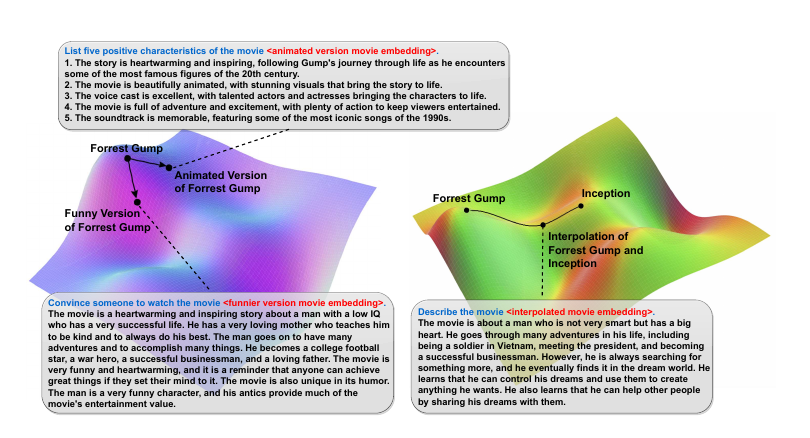


#### Embeddings in der Praxis

Wir benutzen der Einfachheit halber hier auch die Endpunkte von OpenAI für den Embeddingprozess. Natürlich kann man auch lokal ein kleines Embedding-Modell betreiben oder z.B. MixedBread verwenden.
Implizit zahlen wir beim Embedding auch eine kleine Summe an OpenAI, damit sie uns den Prozess abnehmen.

#### Wie sieht so ein Embedding aus?


In [ ]:
from helpers import embeddings
from dotenv import load_dotenv

load_dotenv()

query_result = embeddings().embed_query("Hello, hello World")

print("Dimensions: ", len(query_result))
print(query_result[:3])

#### Wir bauen einen Mini-Vector-Retriever mit Langchain und FAISS


In [ ]:
from langchain_community.document_loaders.pdf import PyPDFLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.vectorstores.faiss import FAISS


documents = PyPDFLoader("Gastherme Istallationsanleitung.pdf").load()
split_documents = CharacterTextSplitter(
    chunk_size=80, chunk_overlap=64
).split_documents(documents)

langchain_lookup_db = FAISS.from_documents(split_documents, embeddings())
langchain_lookup_retriever = langchain_lookup_db.as_retriever()

In [ ]:
query = "Das Display meiner Heizung zeigt 77. Was ist hier das Problem?"
results = langchain_lookup_retriever.invoke(query)
for index, item in enumerate(results):
    print(f"page {index}\n---------------------------------\n\n")
    print(item.page_content)
    print("\n\n")

### Veranschaulichung von semantischer Nähe mittels Abstandsberechnung der zugehörigen Vektoren.

Kleinere Zahl ≙ Näher an der Referenz


In [ ]:
from helpers import distance_grid
from IPython.display import display

grid = distance_grid(query, [r.page_content for r in results])
display(grid)

#### Was erwartet man hier?


In [ ]:
# Unser Referenzwort
reference = "Ich mag den ICE"
# Wie Nahe sind diese Worte an der Referenz?
test_set = [
    "Ich mag den Regionalzug.",
    "Ich mag Eiscreme.",
    "Ich mag den ICE nicht.",
]

grid = distance_grid(reference, test_set)
display(grid)

#### Jetzt das gleiche Beispiel von oben mit dem neueren Modell von OpenAI


In [ ]:
model_large = embeddings(model="text-embedding-3-large")
grid = distance_grid(reference, test_set, model_large)
display(grid)

## ✅ Aufgabe

Erweitere die Aussagen durch mehr Kontext so, dass die richtige Reihenfolge auftritt.


In [ ]:
# Unser Referenzwort
reference = "... ICE ... "
# Wie Nahe sind diese Worte an der Referenz?
test_set = [
    "Ich mag den Regionalzug.",
    "Ich mag Eiscreme.",
    "Ich mag den ICE nicht.",
]
model_large = embeddings(model="text-embedding-3-large")
grid = distance_grid(reference, test_set, model_large)
display(grid)

## Cross-Encoding ist eine etwas andere Technik als die bisher vorgestellten.

Bei den bisherigen Techniken wurden immer alle Dokumente einer Datenbank im Vorhinein angereichert. Die Anreicherung bestand darin, den Textinhalt in eine Form zu bringen, die der Computer leicht und schnell durchsuchen kann (Vektor/Liste).

Dann wurde eine Suchanfrage auf die Anreicherung geworfen und die ähnlichsten Dokumente wurden zurückgegeben.

Der Cross-Encoder arbeitet anders. Er nimmt zwei Texte und vergleicht sie direkt, ohne Zwischenschritte.

- Der Cross-Encoder braucht etwas Zeit, und weil er immer paarweise arbeitet, ist er nur für eine limitierte Anzahl an Dokumenten geeignet (Laufzeit N^2).
- Der Cross-Encoder ist normalerweise recht zuverlässig und liefert wirklich gute Qualtiät.
- Daher wird der Cross-Encoder überlicherweise dazu verwendet, die Ergebnisse von z.B. einer Dokumentensuche mittels BM25 oder Embeddings zu verfeinern und nur die relevantesten Ergebnisse weiter zu reichen.

Weil wir ohnehin schon PyTorch installiert haben, bauen wir den Reranker außerdem selbst (LangChain ist an der Stelle noch etwas dünn).

#### Links:

- https://www.sbert.net/examples/applications/cross-encoder/README.html
- https://huggingface.co/cross-encoder


### Wir benutzen unseren alten Retriever (k=10) und schalten einen Reranker dahinter


In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder

model = CrossEncoder("cross-encoder/stsb-distilroberta-base")

In [ ]:
retriever = BM25Retriever.from_documents(split_documents, k=10)
query = "What did the president say about Ketanji Brown Jackson"
corpus = [d.page_content for d in retriever.get_relevant_documents(query)]

In [ ]:
from helpers import pretty_print_ranks

ranks = model.rank(query, corpus)
pretty_print_ranks(corpus, ranks)

## Weitere nützliche Anmerkungen

- Es gibt Datenbanken, die Sparse und Dense in einer [Hybrid-Suche](https://python.langchain.com/docs/integrations/retrievers/pinecone_hybrid_search) verheiraten.
- Langchain bietet einen sehr unspezifischen [Ensemble Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/ensemble) um verschiedene Retrieval-Techniken zu verbinden.
- Im Trend sind aktuell auch Matryoshka Embeddings ([hier](https://www.sbert.net/examples/training/matryoshka/README.html) und [hier](https://huggingface.co/blog/matryoshka)). Z.B. das relativ neue `text-embedding-3-large` von OpenAI unterstützt nativ kürzere Embeddings mit geringem Informationsverslust.
- Ein [MultiQueryRetriever](https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever) benutzt ein LLM um aus der Nutzeranfrage eine Handvoll verschiedener Anfragen für das RAG zu generieren. Damit ist die Wahrscheinlichkeit höher, die richtigen Dokumente über semantische Ähnlichkeit zu erhalten.
- Wir haben oben das etwas längliche Dokument `state_of_the_union.txt` in verschiedene Einzeldokumente zerlegt. Dies muss man meist tun. Auch wenn neuere LLMs dazu tendieren, immer mehr Kontextlänge einlesen zu können, möchte man aus Effizienz- und Kostengründen längere Dokumente splitten. Die Ergebnisse sind dann meist auch besser, weil das RAG "auf den Punkt" kommt. Das sehr schlichte RecursiveTextCharacterSplitting ist natürlich nicht die einzige Möglichkeit. [Hier](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb) mehr dazu.
- Das ganze Feld RAG bewegt sich aktuell sehr schnell.
- Es entstehen immer mehr spezialisierte Embeddings gebaut, die in einem Spezialkontext gut arbeiten.
- Was man dann in einem realen Anwendungsfall baut, hängt wohl sehr vom aktuellen Stand der Modelle, der Compliance, den Nutzeranfragen und natürlich den Daten ab. Vermutlich fängt man erst einmal mit einem Embedding-Retriever an, baut zur Not noch einen kleinen Reranker dahinter und erweitert das RAG dann je nach Bedarf. In unserem Workshop können wir unmöglich alle guten Ideen aufgreifen. [Hier](https://python.langchain.com/docs/modules/data_connection/retrievers/) oder auch [hier](https://python.langchain.com/docs/integrations/retrievers) kann man sich inspirieren lassen.

Und zum Abschluss: [Hier](https://huggingface.co/spaces/mteb/leaderboard) findet man das Huggingface Leaderbord zu Embeddings.

Viel Erfolg in der Praxis!
